In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_wine
from sklearn.datasets import load_iris
from sklearn.datasets import fetch_openml
from sklearn.metrics import matthews_corrcoef
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_wine, load_iris
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import csv
import os
import time
import warnings

In [ ]:
datasets = [
    ("Iris", lambda: load_iris()),
    ("WBDC (Breast Cancer Wisconsin Diagnostic)", lambda: fetch_openml(data_id=1510, as_frame=False)),
    ("Spambase", lambda: fetch_openml(name="spambase", version=1, as_frame=False)),
    ("Heart", lambda: fetch_openml(data_id=533, as_frame=False)),
    ("Glass", lambda: fetch_openml(name="glass", version=2, as_frame=False)),
    ("WBC (Breast Cancer Wisconsin Original)", lambda: fetch_openml(data_id=15, as_frame=False)),
    ("Ionosphere", lambda: fetch_openml(name="ionosphere", version=1, as_frame=False)),
    ("Arrhythmia", lambda: fetch_openml(name="arrhythmia", version=1, as_frame=False)),
    ("Multiple Features", lambda: fetch_openml(name="mfeat-factors", version=1, as_frame=False)),
    ("Australian", lambda: fetch_openml(name="australian", as_frame=False)),
    ("German Number (Credit Dataset)", lambda: fetch_openml(name="credit-g", version=1, as_frame=False)),
    ("DNA", lambda: fetch_openml(name="dna", version=1, as_frame=False)),
    ("Wine", lambda: load_wine()),
    ("Vehicle", lambda: fetch_openml(name="vehicle", version=2, as_frame=False)),
    ("Waveform", lambda: fetch_openml(name="waveform-5000", version=2, as_frame=False)),
    ("Zoo", lambda: fetch_openml(name="zoo", version=2, as_frame=False)),
    ("Hillvalley", lambda: fetch_openml(name="hill-valley", version=2, as_frame=False)),
    ("Sonar", lambda: fetch_openml(name="sonar", version=1, as_frame=False)),
    ("Musk 1", lambda: fetch_openml(name="musk", version=1, as_frame=False))
]


In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
scorer = make_scorer(roc_auc_score, multi_class='ovo', needs_proba=True)

In [ ]:
def Baseline(estimator, fold=10, X=None, y=None, scoring='accuracy', param_grid=None, dataset_name="dataset", output_dir="results"):
    """
    Baseline evaluation function for a given estimator with optional hyperparameter tuning.
    Saves the results to a CSV file and returns a dictionary of evaluation metrics.
    """
    scoring_functions = {
        'accuracy': make_scorer(accuracy_score),
        'f1_score': make_scorer(f1_score, average='weighted'),
        'matthews_corrcoef': make_scorer(matthews_corrcoef)
    }

    if scoring not in scoring_functions:
        raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

    # Create preprocessing steps for all features
    preprocessor = ColumnTransformer(
        transformers=[('onehot', OneHotEncoder(handle_unknown='ignore'), X.columns)]
    )

    # Create a pipeline with the preprocessor and the estimator
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', estimator)])

    # Perform hyperparameter tuning with GridSearchCV if param_grid is provided
    if param_grid:
        cv = StratifiedKFold(n_splits=fold, shuffle=True, random_state=42)
        grid_search = GridSearchCV(pipeline, param_grid, cv=cv, scoring=scoring_functions[scoring], error_score='raise')
        grid_search.fit(X, y)
        best_estimator = grid_search.best_estimator_
        best_params = grid_search.best_params_
    else:
        pipeline.fit(X, y)
        best_estimator = pipeline
        best_params = {}

    # Perform cross-validation with the best estimator
    scores = cross_val_score(best_estimator, X, y, cv=fold, scoring=scoring_functions[scoring])

    # Calculate AUC and standard deviation
    auc_score = scores.mean()
    auc_std = scores.std()

    # Return results as a dictionary
    return {
        'Framework': type(estimator).__name__,
        'Dataset': dataset_name,
        'AUC': auc_score,
        'AUC_STD': auc_std,
        'Best_Params': best_params
    }



In [ ]:
# Parameters for hyperparameter tuning
param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

results = []
output_dir = "results"

# Single CSV file to store all results
results_file = os.path.join(output_dir, "baseline_results_with_timings.csv")
os.makedirs(output_dir, exist_ok=True)

# Ensure the CSV file starts with headers
with open(results_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Dataset", "Framework", "AUC", "AUC_STD", "Best_Params", "Time_Taken"])

# Iterate over datasets
for dataset_name, loader in datasets:
    try:
        # Load data
        data = loader()
        X, y = (data.data, data.target) if hasattr(data, 'data') else (data['data'], data['target'])

        # Convert X to DataFrame for compatibility
        X = pd.DataFrame(X)

        # Record dataset evaluation start time
        dataset_start_time = time.time()

        # Run baseline evaluation
        result = Baseline(
            estimator=KNeighborsClassifier(),
            fold=10,
            X=X,
            y=y,
            scoring='accuracy',
            param_grid=param_grid,
            dataset_name=dataset_name,
            output_dir=output_dir
        )

        # Add time taken for the dataset
        result['Time_Taken'] = time.time() - dataset_start_time

        # Append results
        results.append(result)

        # Write results directly to the single CSV file
        with open(results_file, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([
                result['Dataset'],
                result['Framework'],
                result['AUC'],
                result['AUC_STD'],
                result['Best_Params'],
                result['Time_Taken']
            ])

    except Exception as e:
        print(f"Error with dataset {dataset_name}: {e}")

# Print all results
for res in results:
    print(res)


{'Framework': 'KNeighborsClassifier', 'Dataset': 'Iris', 'AUC': 0.8533333333333335, 'AUC_STD': 0.07180219742846006, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}, 'Time_Taken': 0.8539047241210938}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'WBDC (Breast Cancer Wisconsin Diagnostic)', 'AUC': 0.6854323308270677, 'AUC_STD': 0.04093269008836167, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 2.7558703422546387}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Spambase', 'AUC': 0.7989625577666699, 'AUC_STD': 0.024622408860984428, 'Best_Params': {'classifier__n_neighbors': 5, 'classifier__weights': 'distance'}, 'Time_Taken': 25.613399028778076}
{'Framework': 'KNeighborsClassifier', 'Dataset': 'Heart', 'AUC': 0.8191883116883115, 'AUC_STD': 0.045507263028688995, 'Best_Params': {'classifier__n_neighbors': 7, 'classifier__weights': 'uniform'}, 'Time_Taken': 1.0964460372924805}
{'Framework': 'KNeighborsClass

In [ ]:
class SAGAFS_GA(BaseEstimator, ClassifierMixin):

    def __init__(self, estimator, cv, scoring='accuracy', population_size=20, generations=10, mutation_rate=0.1, crossover_rate=0.5):
        if not hasattr(estimator, 'fit'):
            raise ValueError("Estimator must have a 'fit' method.")
        if not hasattr(cv, 'split'):
            raise ValueError("cv must be a cross-validation splitter (e.g., StratifiedKFold).")
        if scoring not in ['accuracy', 'matthews_corrcoef', 'f1_score']:
            raise ValueError(f"Scoring method '{scoring}' is not valid. Choose 'accuracy', 'matthews_corrcoef', or 'f1_score'.")

        self.estimator = estimator
        self.cv = cv
        self.scoring = scoring
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.fitness_score = None
        self.best_scores_per_gen = []  # Best fitness scores per generation
        self.avg_scores_per_gen = []  # Average fitness scores per generation
        self.best_individual = None  # Store the best individual

    def fit(self, X, y, dataset_name=None, output_dir="results"):
      n_features = X.shape[1]

      # Initialize population: binary vectors where 1 means feature selected and 0 not selected
      population = [np.random.randint(2, size=n_features) for _ in range(self.population_size)]

      generation_times = []  # Store time per generation
      individual_times = []  # Store time per individual

      for generation in range(self.generations):
          generation_start_time = time.time()  # Start timing the generation

          fitness_scores = []
          for individual in population:
              individual_start_time = time.time()  # Start timing the individual
              fitness = self.fitness_function(X, y, individual)
              individual_times.append(time.time() - individual_start_time)  # Record time per individual
              fitness_scores.append(fitness)

          # Best and average fitness of the current generation
          best_fitness = max(fitness_scores)
          avg_fitness = np.mean(fitness_scores)

          self.best_scores_per_gen.append(best_fitness)
          self.avg_scores_per_gen.append(avg_fitness)

          # Sort population based on fitness scores (highest fitness first)
          sorted_population = [x for _, x in sorted(zip(fitness_scores, population), key=lambda item: item[0], reverse=True)]

          # Elitism: Keep the top individuals
          population = sorted_population[:self.population_size // 2]

          # Create next generation through crossover and mutation
          while len(population) < self.population_size:
              parents = random.sample(population, 2)

              # Use Crossover and Mutation from the child classes
              crossover_obj = self.Crossover(self.crossover_rate)
              mutation_obj = self.Mutation(self.mutation_rate)

              child1, child2 = crossover_obj.apply(parents[0], parents[1])

              # Apply mutation
              if random.random() < self.mutation_rate:
                  child1 = mutation_obj.apply(child1)
              if random.random() < self.mutation_rate:
                  child2 = mutation_obj.apply(child2)

              population.append(child1)
              population.append(child2)

          generation_times.append(time.time() - generation_start_time)  # Record time per generation

      # Select the best individual after all generations
      self.best_individual = max(population, key=lambda individual: self.fitness_function(X, y, individual))
      self.fitness_score = self.fitness_function(X, y, self.best_individual)

      # Perform cross-validation to compute AUC and AUC_STD
      selected_features = np.where(self.best_individual == 1)[0]
      X_selected = X[:, selected_features]
      scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=scorer)
      auc_score = np.mean(scores)
      auc_std = np.std(scores)

      # Get best parameters (not relevant for KNeighborsClassifier, but placeholder for other models)
      best_params = self.estimator.get_params()

      # Save results
      if dataset_name:
          self.save_results(dataset_name, output_dir, auc_score, auc_std, best_params)

      return self.fitness_score

    def fitness_function(self, X, y, feature_subset):
        selected_features = np.where(feature_subset == 1)[0]

        if selected_features.size == 0:
            return 0  # No features selected, return a poor fitness score

        try:
            # Perform cross-validation using only the selected features
            X_selected = X[:, selected_features]
            scores = cross_val_score(self.estimator, X_selected, y, cv=self.cv, scoring=self.scoring)
        except Exception as e:
            print(f"Error during cross-validation: {e}")
            return 0  # Return a poor fitness score if cross-validation fails

        return np.mean(scores)

    def save_results(self, dataset_name, output_dir, auc_score, auc_std, best_params):
      """
      Save the results in the desired format.
      """
      # Ensure output directory exists
      os.makedirs(output_dir, exist_ok=True)

      # Define the summary CSV file path
      summary_file = os.path.join(output_dir, "model_performance_summary.csv")

      # Check if the file exists to determine whether to write the header
      file_exists = os.path.isfile(summary_file)

      # Append the new dataset results to the summary CSV
      with open(summary_file, mode='a', newline='') as file:
          writer = csv.writer(file)

          # Write header only if file doesn't already exist
          if not file_exists:
              writer.writerow([
                  "Dataset",
                  f"{type(self.estimator).__name__}_AUC",
                  f"{type(self.estimator).__name__}_AUC_STD",
                  f"{type(self.estimator).__name__}_Best_Params"
              ])

          # Write the dataset's results
          writer.writerow([dataset_name, auc_score, auc_std, best_params])

    def save_timing_info(self, dataset_name, output_dir, generation_times, individual_times):
      """
      Save timing information for a single dataset to a separate CSV file.
      """
      # Ensure output directory exists
      os.makedirs(output_dir, exist_ok=True)

      # Define the timing info CSV file path
      timing_file = os.path.join(output_dir, "timing_info.csv")

      # Check if the file exists to determine whether to write the header
      file_exists = os.path.isfile(timing_file)

      # Append the new dataset's timing information to the CSV
      with open(timing_file, mode='a', newline='') as file:
          writer = csv.writer(file)

          # Write header only if file doesn't already exist
          if not file_exists:
              writer.writerow([
                  "Dataset",
                  "Average_Generation_Time",
                  "Average_Individual_Time",
                  "Total_Generations",
                  "Total_Individuals"
              ])

          # Calculate average times
          avg_generation_time = np.mean(generation_times)
          avg_individual_time = np.mean(individual_times)

          # Write timing information
          writer.writerow([
              dataset_name,
              avg_generation_time,
              avg_individual_time,
              len(generation_times),
              len(individual_times)
          ])


    def plot_heatmap(self, feature_scores, feature_names):
        if len(feature_scores) != len(feature_names):
            raise ValueError("Feature scores and feature names must have the same length.")

        feature_scores_reshaped = np.array(feature_scores).reshape(1, -1)
        plt.figure(figsize=(10, 1))
        sns.heatmap(feature_scores_reshaped, annot=True, cmap="coolwarm", xticklabels=feature_names, yticklabels=["Score"])
        plt.title("Feature Importance Heatmap")
        plt.show()

    def plot_fitness_over_generations(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, self.generations + 1), self.best_scores_per_gen, marker='o', color='b')
        plt.title("Fitness Score Evolution Over Generations")
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness Score")
        plt.grid(True)
        plt.show()

    def create_feature_names_dict(self, feature_names):
        """
        Create a dictionary of feature names.
        - feature_names: A list of feature names.
        Returns a dictionary where the key is the feature index (1-based)
        and the value is the feature name.
        """
        self.feature_names_dict = {i + 1: str(i + 1) for i in range(feature_names)}
        return self.feature_names_dict

    # Child class for crossover
    class Crossover:
        def __init__(self, crossover_rate):
            self.crossover_rate = crossover_rate

        def apply(self, parent1, parent2):
            """
            Crossover implementation based on the provided diagram.
            """
            n_features = len(parent1)
            o1 = []  # Offspring 1
            o2 = []  # Offspring 2

            # Step (a): Add common feature indices (features that both parents share)
            common_features = np.where((parent1 == parent2) & (parent1 == 1))[0]
            o1.extend(common_features)
            o2.extend(common_features)

            # Step (b): Identify non-shared features
            nC1 = np.where((parent1 == 1) & (parent2 == 0))[0]
            nC2 = np.where((parent2 == 1) & (parent1 == 0))[0]

            # Step (c): Randomly decide which non-shared features to add to which offspring
            for feature in nC1:
                if random.random() <= 0.66:  # As per the diagram, threshold is 0.66
                    o1.append(feature)
                else:
                    o2.append(feature)

            for feature in nC2:
                if random.random() <= 0.33:  # As per the diagram, threshold is 0.33
                    o2.append(feature)
                else:
                    o1.append(feature)

            # Create binary vectors from the selected feature indices
            child1 = np.zeros(n_features)
            child2 = np.zeros(n_features)
            child1[o1] = 1
            child2[o2] = 1
            print("Child1: ", child1, "Using parent1: ", parent1, " and parent2: ", parent2)
            print("Child2: ", child2)

            return child1, child2

    # Child class for mutation
    class Mutation:
        def __init__(self, mutation_rate):
            self.mutation_rate = mutation_rate

        def apply(self, individual):
            """
            Mutation: randomly flip a feature bit in the individual.
            """
            mutation_point = random.randint(0, len(individual) - 1)
            individual[mutation_point] = 1 - individual[mutation_point]  # Flip the bit
            return individual


# Using KNeighborsClassifier on every dataset from above list


Processing dataset: Iris
Child1:  [0. 0. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [0 0 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0 0 1 1]  and parent2:  [1 1 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 1. 1. 1.] Using parent1:  [0 1 1 0]  and parent2:  [0. 0. 1. 1.]
Child2:  [0. 0. 1. 0.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1 1 1 1]  and parent2:  [0 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [0 0 1 1]
Child2:  [1. 1. 1. 1.]
Child1:  [0. 0. 1. 1.] Using parent1:  [0. 0. 1. 1.]  and parent2:  [0 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [0 0 1 1]
Child2:  [0. 0. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [1. 1. 1. 1.]
Child2:  [1. 1. 1. 1.]
Child1:  [1. 1. 1. 1.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [1

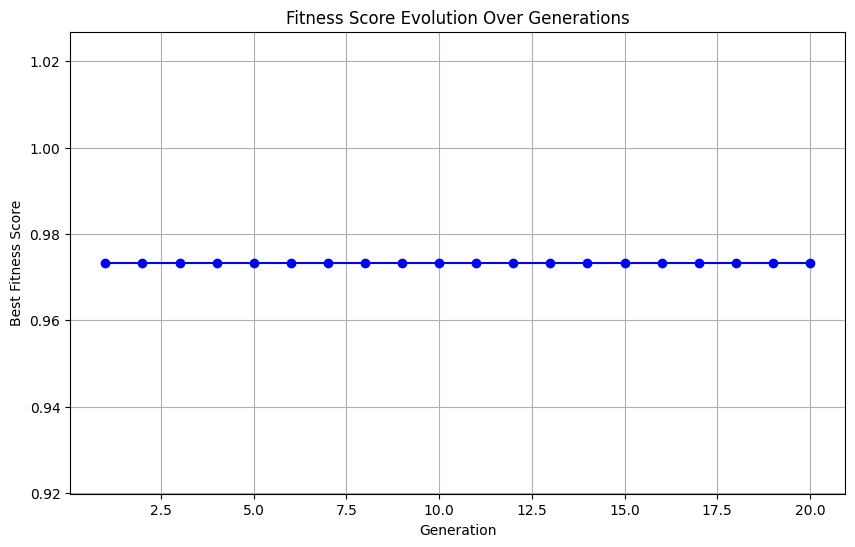

Processing dataset: WBDC (Breast Cancer Wisconsin Diagnostic)
Child1:  [0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 1. 0.] Using parent1:  [0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 0]  and parent2:  [0 1 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 0]
Child2:  [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 0.]
Child1:  [0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 0. 1. 0.] Using parent1:  [0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 0 0 0]  and parent2:  [0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 0. 1. 0. 1. 0.]
Child2:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0.
 0. 0. 1. 0. 0. 0.]
Child1:  [0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 0.] Using parent1:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0

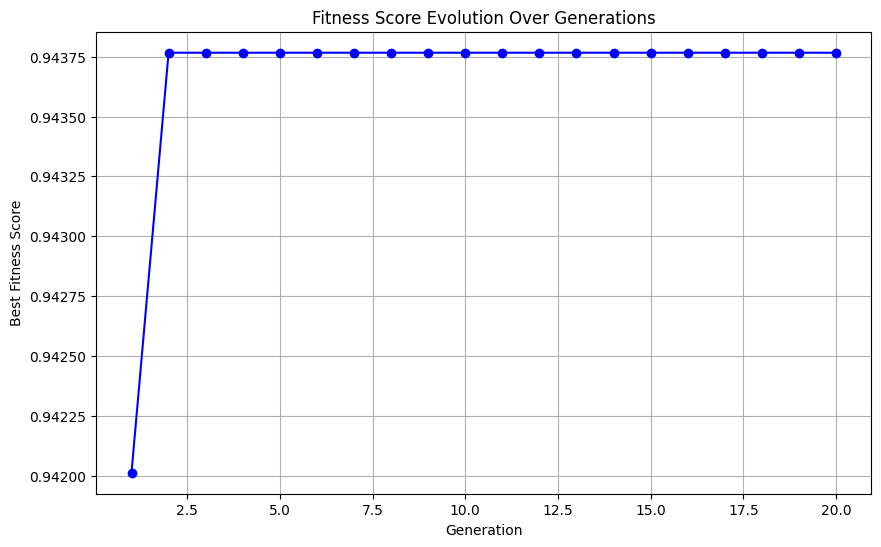

Processing dataset: Spambase
Child1:  [1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 0. 1.] Using parent1:  [1 0 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 0 0 0 0 0
 1 0 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 1]  and parent2:  [0 1 0 0 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1
 1 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 1 0 1]
Child2:  [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Child1:  [0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1.] Using parent1:  [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1

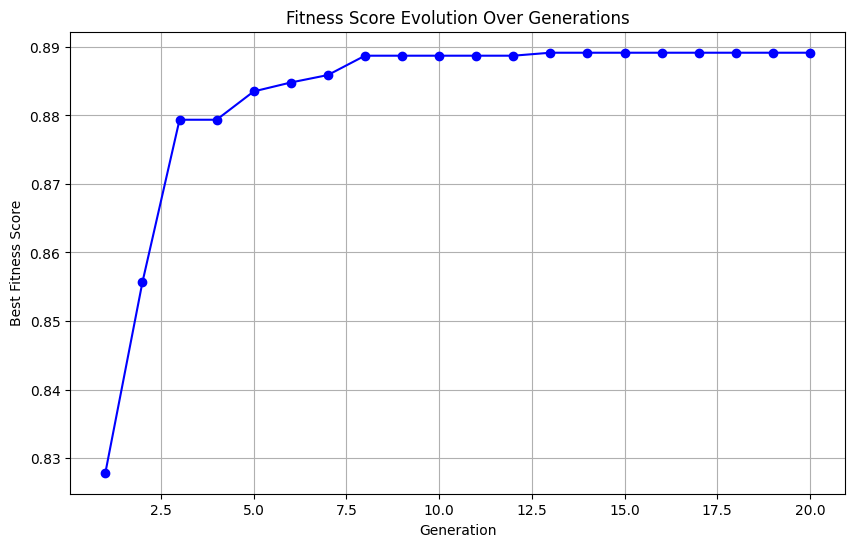

Processing dataset: Heart
Child1:  [1. 1. 1. 1.] Using parent1:  [1 0 0 1]  and parent2:  [1 1 1 1]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 1. 1. 0.] Using parent1:  [1. 1. 1. 1.]  and parent2:  [1 0 1 0]
Child2:  [1. 0. 1. 1.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1 0 1 1]  and parent2:  [1 0 1 0]
Child2:  [1. 0. 1. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1 0 0 1]  and parent2:  [0. 0. 1. 0.]
Child2:  [0. 0. 0. 0.]
Child1:  [1. 0. 1. 1.] Using parent1:  [1. 0. 1. 1.]  and parent2:  [1 0 0 1]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1 0 0 1]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and parent2:  [1. 0. 0. 1.]
Child2:  [1. 0. 0. 1.]
Child1:  [1. 0. 0. 1.] Using parent1:  [1. 0. 0. 1.]  and par

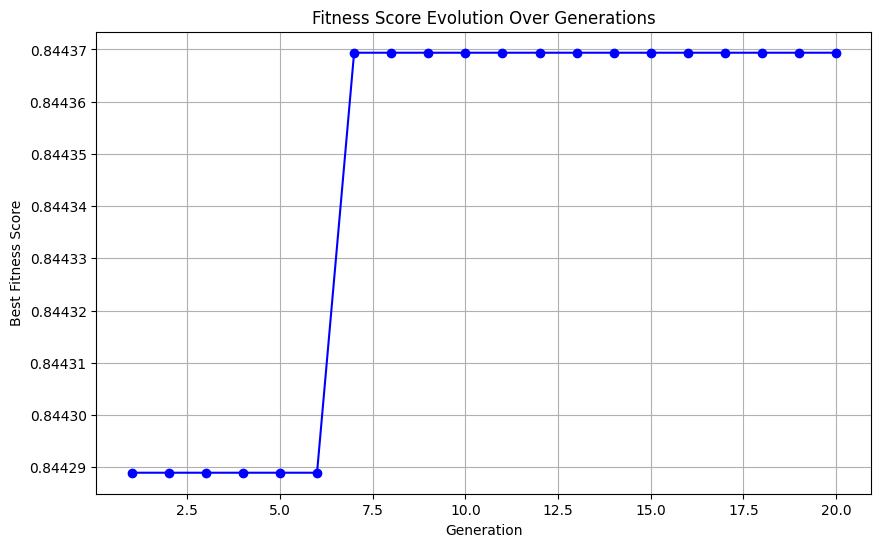

Processing dataset: Glass
Child1:  [0. 1. 1. 0. 1. 1. 1. 1. 0.] Using parent1:  [0 1 0 0 1 0 1 1 0]  and parent2:  [0 1 1 1 1 1 1 1 0]
Child2:  [0. 1. 0. 1. 1. 0. 1. 1. 0.]
Child1:  [1. 1. 1. 0. 1. 0. 0. 1. 1.] Using parent1:  [0 1 0 0 1 0 1 1 0]  and parent2:  [1 1 1 1 1 0 0 0 1]
Child2:  [0. 1. 0. 1. 1. 0. 1. 0. 0.]
Child1:  [0. 1. 0. 0. 1. 0. 1. 1. 0.] Using parent1:  [0. 1. 0. 1. 1. 0. 1. 0. 0.]  and parent2:  [0. 1. 1. 0. 1. 1. 1. 1. 0.]
Child2:  [0. 1. 1. 1. 1. 1. 1. 0. 0.]
Child1:  [0. 1. 1. 1. 1. 0. 1. 0. 1.] Using parent1:  [1 1 1 1 0 1 1 0 1]  and parent2:  [0. 1. 0. 0. 1. 0. 1. 1. 0.]
Child2:  [1. 1. 0. 0. 0. 1. 1. 1. 0.]
Child1:  [1. 1. 1. 1. 0. 1. 1. 1. 0.] Using parent1:  [1. 1. 0. 0. 0. 1. 1. 1. 0.]  and parent2:  [1 1 1 1 1 1 1 1 0]
Child2:  [1. 1. 0. 0. 1. 1. 1. 1. 0.]
Child1:  [1. 1. 0. 0. 1. 0. 1. 1. 0.] Using parent1:  [1. 1. 0. 0. 0. 1. 1. 1. 0.]  and parent2:  [0 1 0 0 1 0 1 1 0]
Child2:  [0. 1. 0. 0. 0. 1. 1. 1. 0.]
Child1:  [1. 1. 1. 1. 0. 1. 1. 0. 0.] Using par

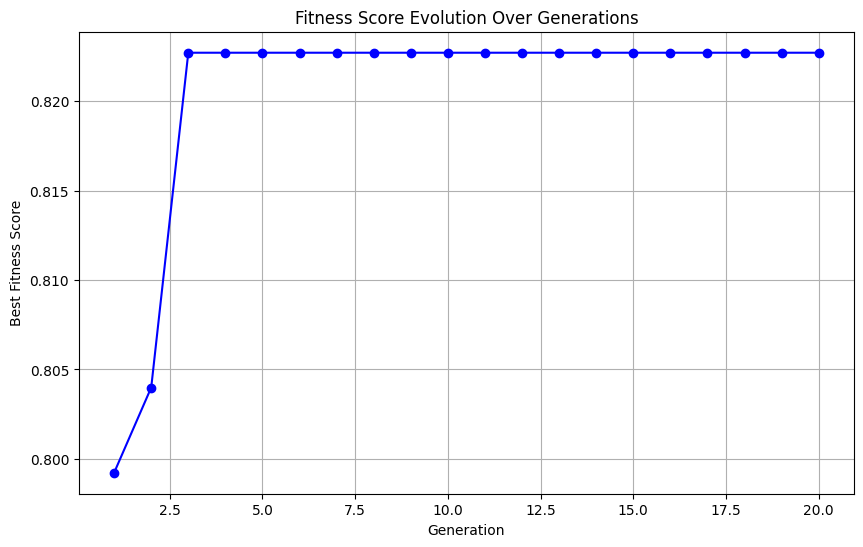

Processing dataset: WBC (Breast Cancer Wisconsin Original)
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "

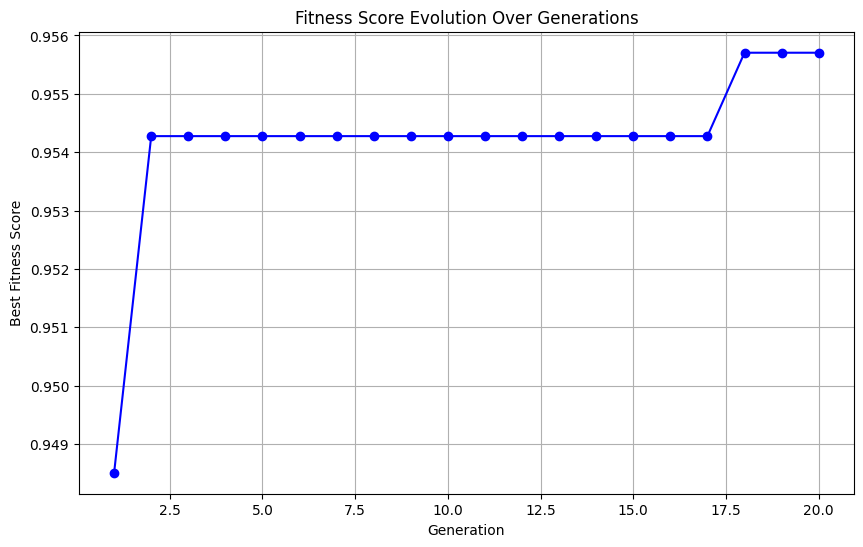

Processing dataset: Ionosphere
Child1:  [0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] Using parent1:  [0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 1 0]  and parent2:  [1 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1]
Child2:  [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
Child1:  [1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 0.] Using parent1:  [0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1]  and parent2:  [1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 1. 1. 0. 0. 1. 0.]
Child2:  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 1.]
Child1:  [1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.] Using parent1:  [1 0 1

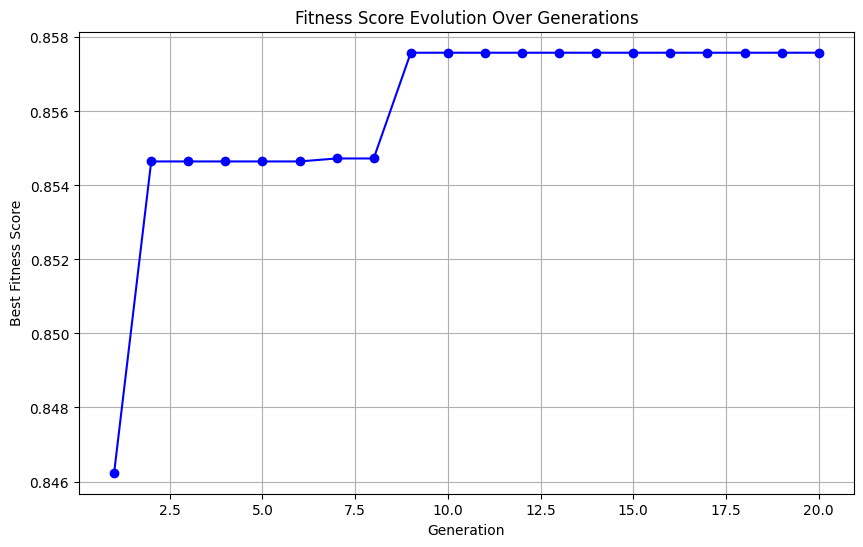

Processing dataset: Arrhythmia
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/di

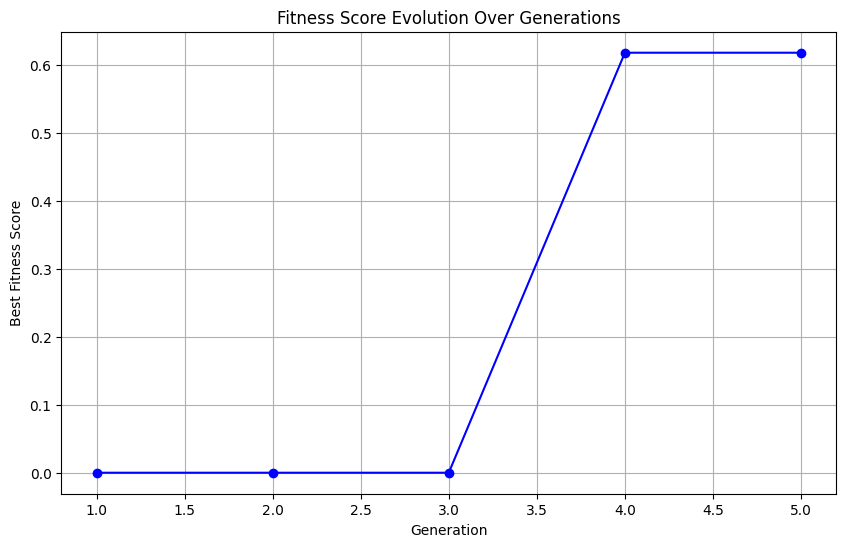

Processing dataset: Multiple Features
Child1:  [1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0.
 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.] Using parent1:  [1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0
 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1
 0 1 1 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 0 0 1 1

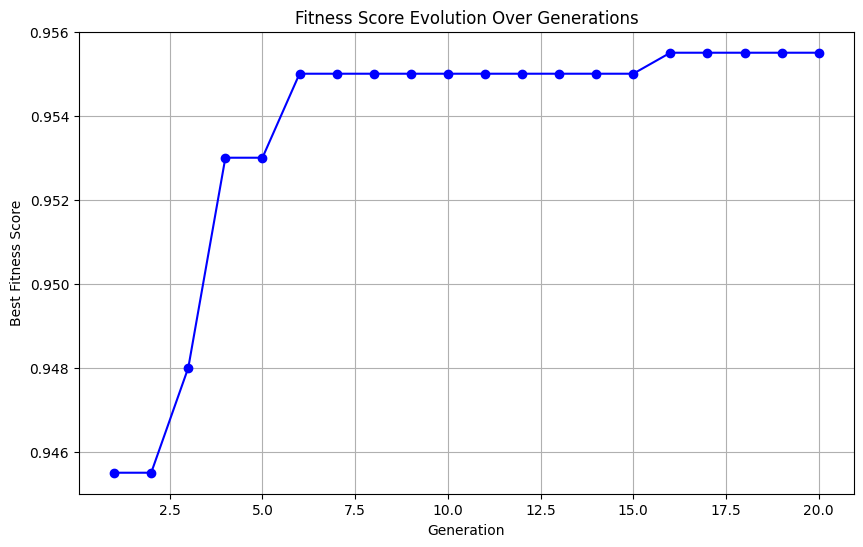

Processing dataset: Australian
Child1:  [0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.] Using parent1:  [0 1 1 1 0 1 1 1 1 0 1 1 0 1]  and parent2:  [0 0 1 0 1 0 0 0 0 0 0 0 0 1]
Child2:  [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.]
Child1:  [0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.] Using parent1:  [0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1.]  and parent2:  [0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1.]
Child2:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]
Child1:  [0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1.] Using parent1:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1.]  and parent2:  [0 0 0 0 1 0 0 0 1 0 0 1 1 1]
Child2:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.]
Child1:  [0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1.] Using parent1:  [0 1 1 1 0 1 1 1 1 0 1 1 0 1]  and parent2:  [0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Child2:  [0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.]
Child1:  [0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.] Using parent1:  [0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1.]  and parent2

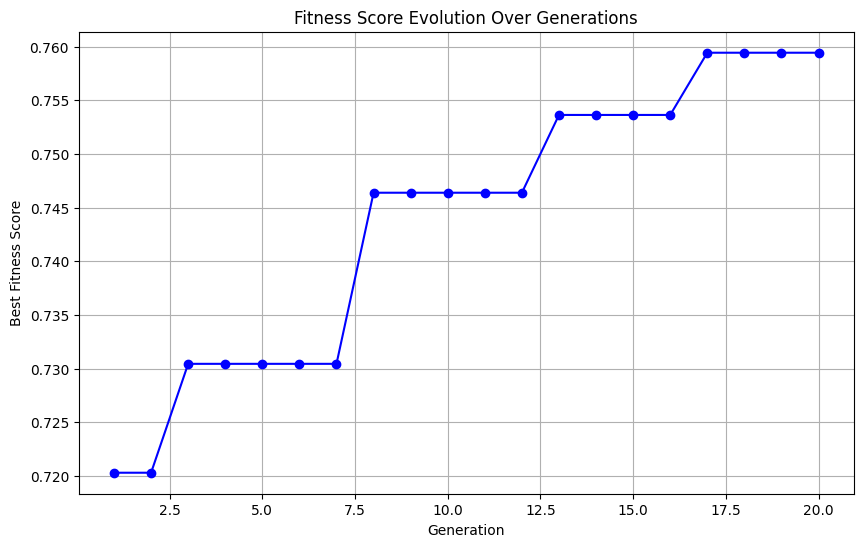

Streaming output truncated to the last 5000 lines.
    array = numpy.asarray(array, order=order, dtype=dtype)
ValueError: could not convert string to float: 'no checking'

--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = chec

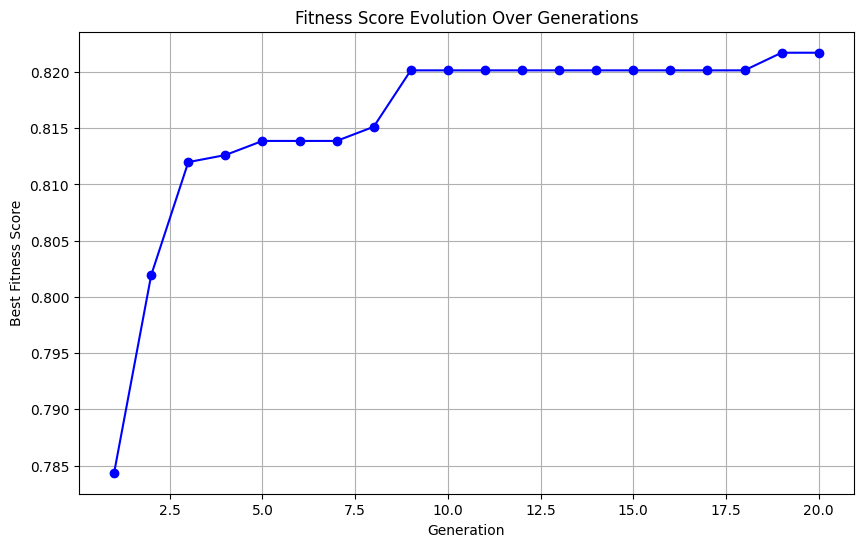

Processing dataset: Wine
Child1:  [1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1.] Using parent1:  [0 1 1 0 1 0 0 0 0 1 0 1 1]  and parent2:  [1 0 0 1 1 0 1 1 1 0 0 0 1]
Child2:  [0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1.]
Child1:  [1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1.] Using parent1:  [1 0 0 1 1 0 1 1 1 0 0 0 1]  and parent2:  [1 1 0 0 1 0 1 1 1 0 0 0 1]
Child2:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
Child1:  [0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.] Using parent1:  [1 0 0 1 1 0 1 1 1 0 0 0 1]  and parent2:  [0 1 0 1 0 0 1 1 1 1 0 0 0]
Child2:  [1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
Child1:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.] Using parent1:  [1 0 0 1 1 0 1 1 1 0 0 0 1]  and parent2:  [1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
Child2:  [1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.]
Child1:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.] Using parent1:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]  and parent2:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
Child2:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 0. 1.]
C

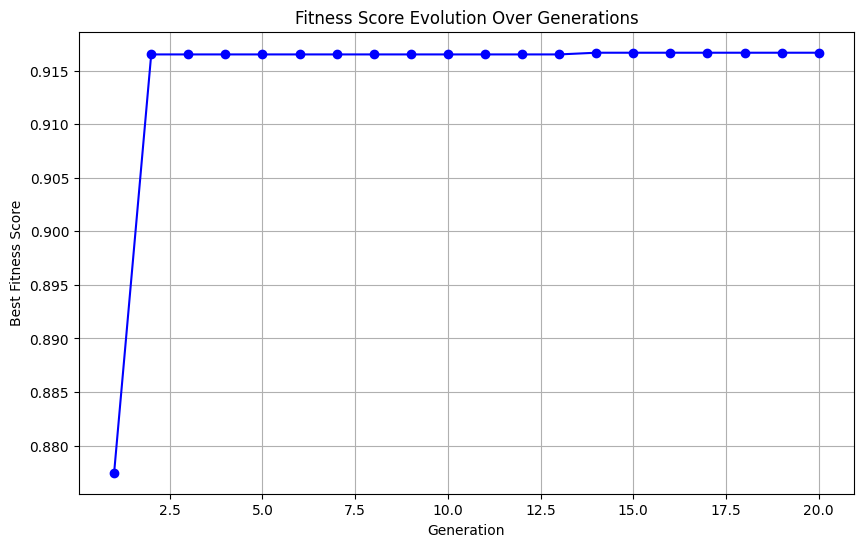

Processing dataset: Vehicle
Child1:  [0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.] Using parent1:  [0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1]  and parent2:  [0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1]
Child2:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Child1:  [0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.] Using parent1:  [0 1 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 1]  and parent2:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Child2:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Child1:  [0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1.] Using parent1:  [0 1 0 1 1 1 1 0 0 1 1 1 0 1 1 0 0 1]  and parent2:  [0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Child2:  [0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1.]
Child1:  [0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1.] Using parent1:  [0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1 1]  and parent2:  [0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1.]
Child2:  [0. 1. 1. 0. 1. 0. 0. 1. 1

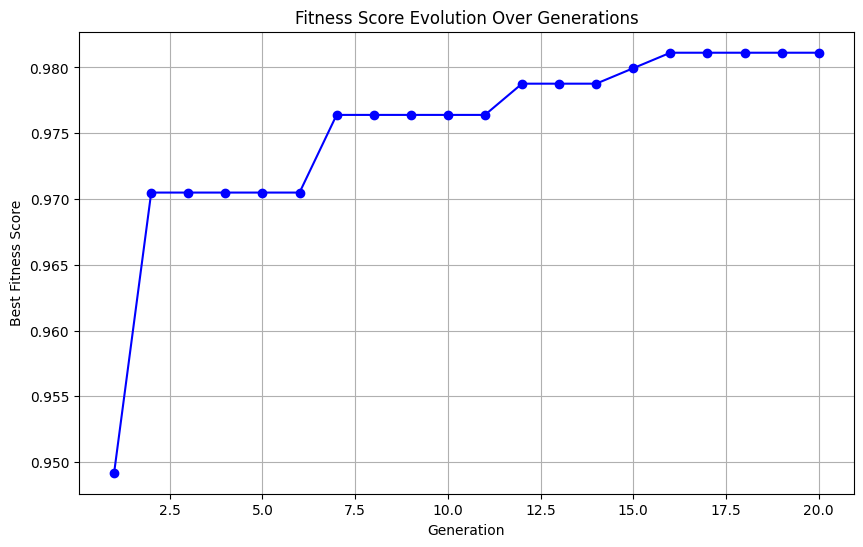

Processing dataset: Waveform
Child1:  [1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1.] Using parent1:  [1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1
 0 1 1]  and parent2:  [1 0 1 0 1 0 1 0 0 0 1 1 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0
 1 1 1]
Child2:  [1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1.]
Child1:  [1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.] Using parent1:  [1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 1 1
 0 1 1]  and parent2:  [1 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0
 1 1 1]
Child2:  [1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1.]
Child1:  [1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 

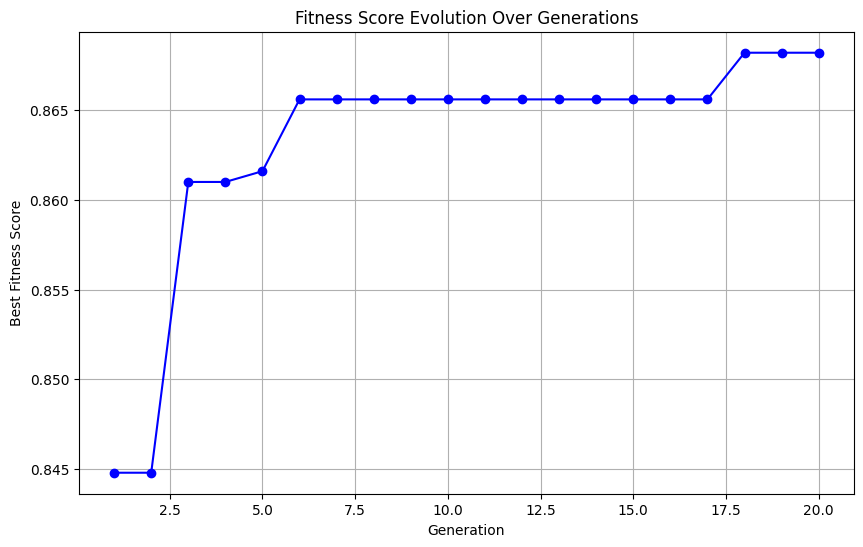

Streaming output truncated to the last 5000 lines.
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 650, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1301, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1012, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_arra

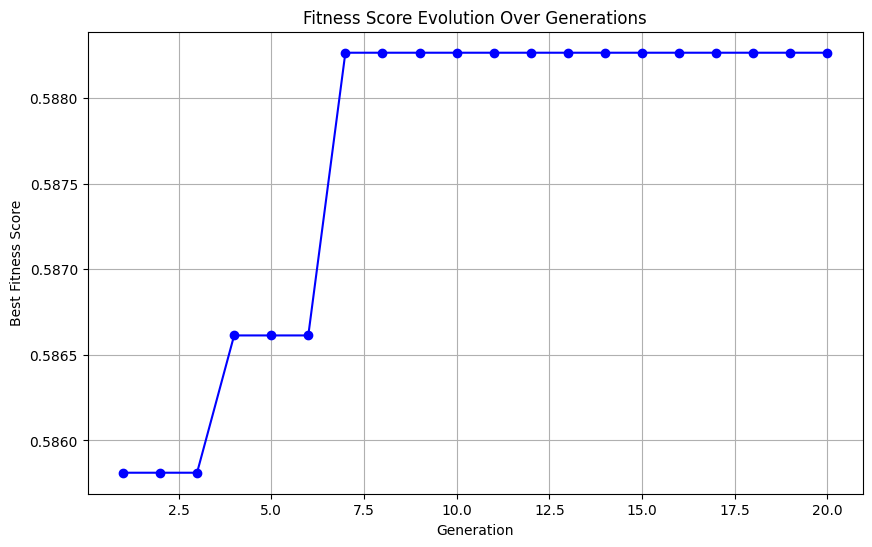

Processing dataset: Sonar
Child1:  [0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.] Using parent1:  [0 0 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1
 1 0 1 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0]  and parent2:  [1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0
 0 1 0 0 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 1 0]
Child2:  [1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0.]
Child1:  [0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0.] Using parent1:  [0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 1. 0. 0. 1. 1. 1

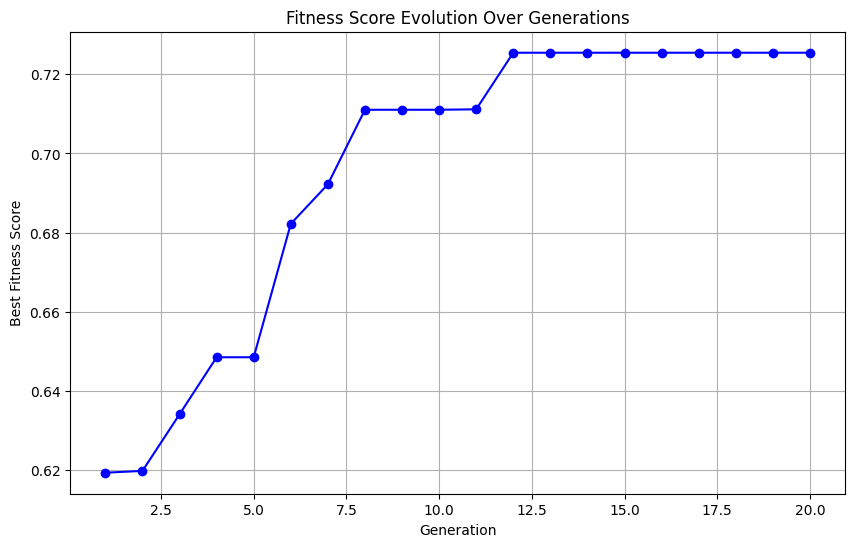

Processing dataset: Musk 1
Error during cross-validation: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py", line 238, in fit
    return self._fit(X, y)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_base.py", line 475, in _fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-p

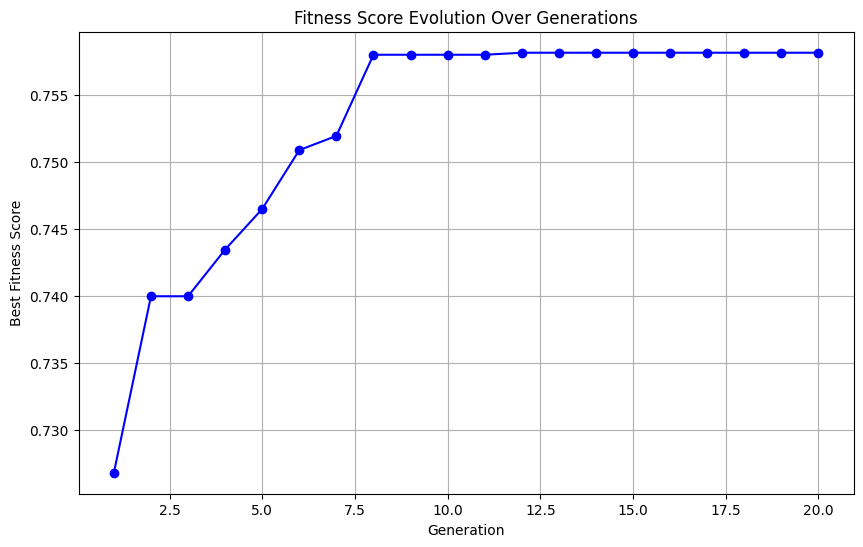

In [ ]:
# Define the estimator and cross-validation strategy
estimator = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5)
output_dir = "results"

for dataset_name, dataset_loader in datasets:
    print(f"Processing dataset: {dataset_name}")
    try:
        data = dataset_loader()
        X, y = (data.data, data.target) if hasattr(data, 'data') else (data[0], data[1])

        # Instantiate the SAGAFS_GA class
        ga_fs = SAGAFS_GA(estimator=estimator, cv=cv, scoring='accuracy', population_size=10, generations=20)

        # Fit the model and save results
        best_fitness = ga_fs.fit(X, y, dataset_name=dataset_name, output_dir=output_dir)

        print(f"Best Fitness Score for {dataset_name}: {best_fitness}")
        ga_fs.plot_fitness_over_generations()
    except Exception as e:
        print(f"An error occurred with {dataset_name}: {e}")